In [1]:
import os
import cv2
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import keras.backend as K
from keras import Sequential
from time import perf_counter
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from collections import defaultdict
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [3]:
class_mapping = defaultdict(list)

In [4]:
def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [6]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [7]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [8]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [9]:
classes = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 1046333.86it/s]


In [10]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [11]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

Train samples: 15772
Validation samples: 3944
Test samples: 4929


In [12]:
BATCH_SIZE = 16

def image_generator(img_paths, img_labels, batch_s):
    """
    Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_s (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)
    while True:
        for offset in range(0, num_samples, batch_s):
            batch_paths = img_paths[offset:offset + batch_s]
            batch_labels = img_labels[offset:offset + batch_s]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(img_path)
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [13]:
train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [14]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 6)                 0   

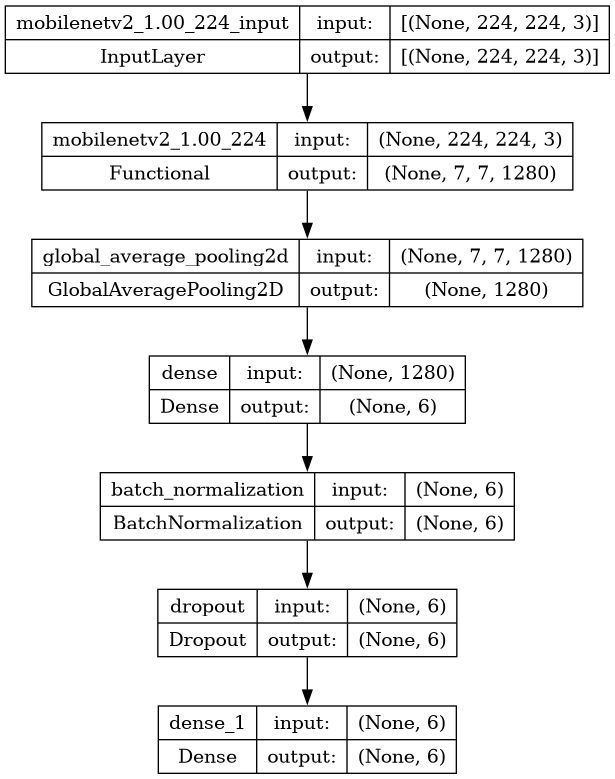

In [16]:
plot_model(model, show_shapes=True)

In [17]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [18]:
early_stopping = EarlyStopping(patience=5)

In [19]:
TOTAL_EPOCHS = 25

start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[early_stopping],
    validation_data=val_generator,
    validation_steps=val_steps
)
end_time = perf_counter()

Epoch 1/25
985/985 [==============================] - 292s 264ms/step - loss: 1.1324 - accuracy: 0.5864 - precision: 0.7753 - recall: 0.3690 - f1_score: 0.4903 - specificity: 0.9786 - sensitivity: 0.3690 - mcc: 0.4721 - auc: 0.8741 - val_loss: 1.3040 - val_accuracy: 0.6560 - val_precision: 0.6793 - val_recall: 0.3138 - val_f1_score: 0.4227 - val_specificity: 0.9704 - val_sensitivity: 0.3138 - val_mcc: 0.3936 - val_auc: 0.8272
Epoch 2/25
985/985 [==============================] - 90s 90ms/step - loss: 0.8447 - accuracy: 0.7251 - precision: 0.9000 - recall: 0.5172 - f1_score: 0.6496 - specificity: 0.9885 - sensitivity: 0.5171 - mcc: 0.6370 - auc: 0.9405 - val_loss: 0.7899 - val_accuracy: 0.8382 - val_precision: 0.9579 - val_recall: 0.5783 - val_f1_score: 0.7143 - val_specificity: 0.9949 - val_sensitivity: 0.5783 - val_mcc: 0.7068 - val_auc: 0.9601
Epoch 3/25
985/985 [==============================] - 90s 92ms/step - loss: 0.7225 - accuracy: 0.7812 - precision: 0.9299 - recall: 0.5847 - f

In [20]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 21 minutes, 22 seconds, 834 milliseconds


In [21]:
_ = model.evaluate(test_generator, steps=test_steps)

308/308 [==============================] - 65s 212ms/step - loss: 0.4739 - accuracy: 0.8730 - precision: 0.9338 - recall: 0.7961 - f1_score: 0.8569 - specificity: 0.9887 - sensitivity: 0.7961 - mcc: 0.8369 - auc: 0.9768


In [22]:
def plot_metrics(hist, metric_name_list, y_lim=None):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot
        y_lim: a tuple (min, max) specifying the limits of the y-axis (optional)

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

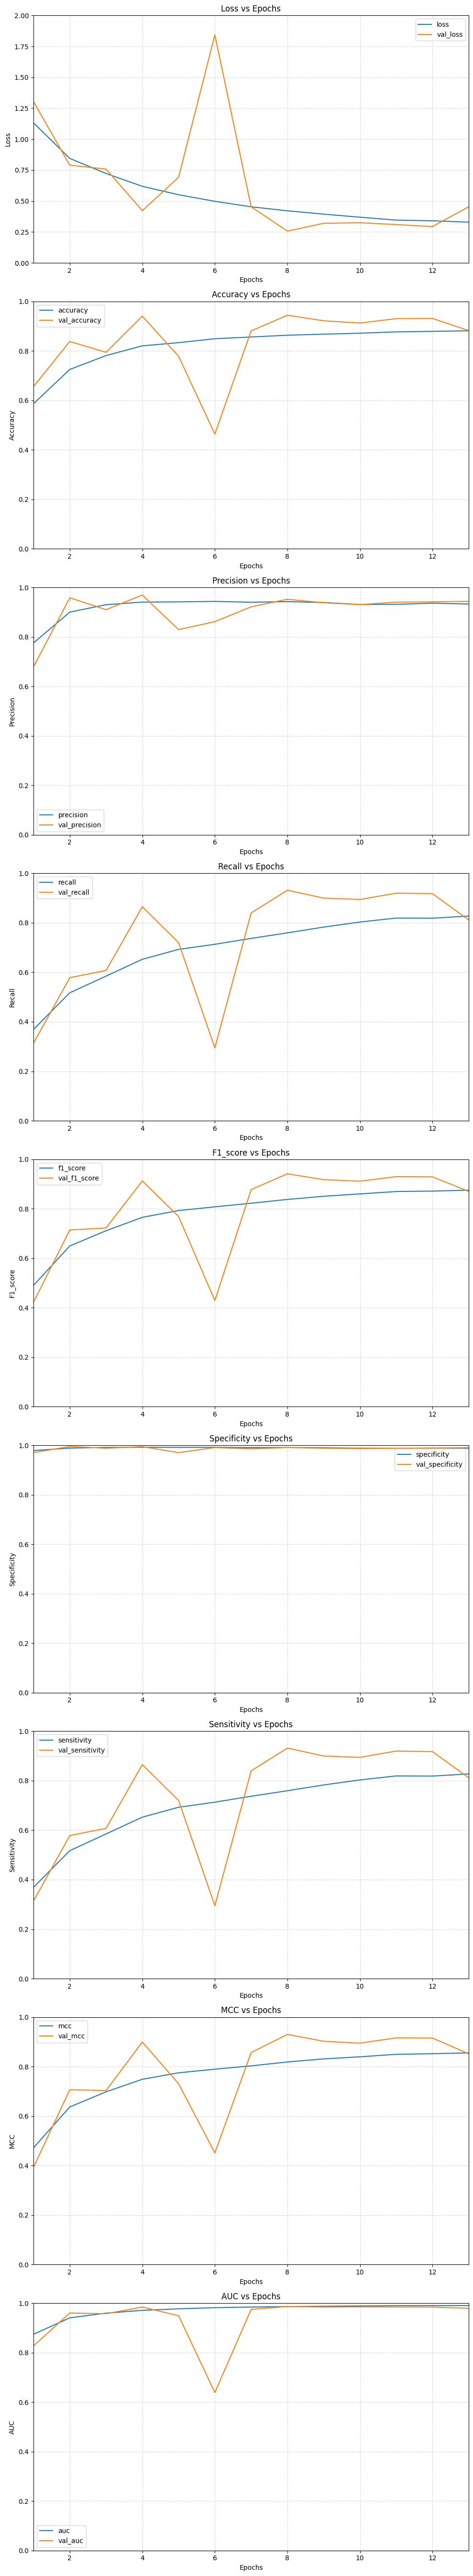

In [23]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names, y_lim=(0, 1))

In [28]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.8236    1.0000    0.9033       537
              COVID     0.9007    0.8968    0.8988       688
       Lung_Opacity     0.8965    0.8393    0.8669      1176
             Normal     0.9538    0.8526    0.9004      2083
       Tuberculosis     0.3898    0.9797    0.5577       148
    Viral Pneumonia     0.9378    0.8043    0.8659       281

           accuracy                         0.8728      4913
          macro avg     0.8170    0.8955    0.8322      4913
       weighted avg     0.9005    0.8728    0.8802      4913

There were 625 errors in 4913 tests for an accuracy of  87.28


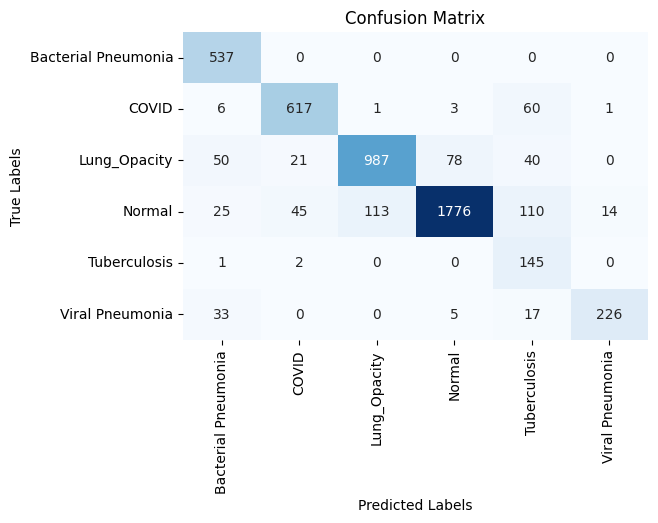

In [29]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()